# Capstone Project - Movie Recommendations for New Users
*Catherine Hocknell* | 10 April, 2023

##### Notebook 2/5

This notebook will go through a number of data wrangling steps that have been used to evaluate the available data in preparation for carrying out the Sentiment Analysis and Recommender Systems. These include:
- Preprocess the text of the *reviews* dataset
- Creating a function to convert a given review when carrying out a sentiment prediction
- Identifying reviewers who have specific opinions on genres within their historic ratings
---
# Data Wrangling

In [1]:
#import all necessary packages

import numpy as np
import pandas as pd

#graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#stats
from scipy import stats
from scipy.stats import norm

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from statsmodels.regression import linear_model 

# nlp packages
import string
import contractions

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0 Data Import
The data required for this notebook is contained within the following .csv files:

|Filename|Description|
|-|-|
|cleaned_reviews_full.csv|Subset of original review dataset containing only reviews with a numeric `final_score`|
|english_reviews_full.csv|Further subset of above dataset which contains only reviews in English|
|rotten_tomatoes_movies.csv|Full movies dataset from Kaggle|

These files are imported and assigned to dataframes below.

In [4]:
# import csvs made from cleaning the original data
# language information
eng_df = pd.read_csv('data/english_reviews_full.csv', index_col = 0)

# full review df content
clean_df = pd.read_csv('data/cleaned_reviews_full.csv', index_col = 0)

# movies df
movies_df = pd.read_csv('data/rotten_tomatoes_movies.csv')

# 1 Review Text Pre-Processing
The first section of this notebook will cover the preprocessing and EDA of the review text content, which will later be used within the Sentiment Analysis. 

## 1.1 Tokenization
When training the model, instead of creating a tokenising function for within the vectoriser, the reviews will be tokenised beforehand. This due to the fact that this will improve the run time of the vectorisers, which is beneficial in this case as multiple vectorisations will be used within the project.

The steps carried out to complete the tokenisation are show in the table below.

|Process|Description|Example|
|-------|-----------|-------|
|**Expand Contractions**| Splits contractions into multiple words |Can't becomes can not|
|**Convert to Lowercase**|Does not separate words based on their capitalisation | Harry becomes harry|
|**Remove Punctuation**|Ensures that any punctuation doesnt count within the vectorisation| N/A|
|**Remove Stopwords**|'Stopwords' are joining words that are generally very common and can skew the data |the, and, a, or etc.|
|**Stemming the Words**|Shortening words to make them more generalised | working becomes work|


### 1.1.1 Expand Contractions
First, the reviews are split into a list of seperate strings (words), then a `contractions` package is used to convert any relevant strings in the list into contractions.
- i.e. can't becomes can not

In [5]:
# create new column 'no cont' which is a list of all words while separating contractions --> i.e. isn't = is not

# lambda function to split all rows in 'review_content' column, then apply 'contractions' function
eng_df['no_cont'] = eng_df['review_content'].apply(lambda x: [contractions.fix(word) for word in x.split()])
eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L..."


In [6]:
# convert list column back to strings without contractions
eng_df['review_str'] = [' '.join(map(str, l)) for l in eng_df['no_cont']]
eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont,review_str
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L...",Whether audiences will get behind The Lightnin...


### 1.1.2 Tokenize the review

Tokenizing splits the words out again into a list containing all the separate strings from within the column in question (in this case, `review_str`). This is different from purely using `.split()` as the `word_tokenize` function also separates the punctuation.

In [7]:
#use tokenize to create a list of strings and punctuation
eng_df['review_split'] = eng_df['review_str'].apply(word_tokenize)

eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont,review_str,review_split
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L...",Whether audiences will get behind The Lightnin...,"[Whether, audiences, will, get, behind, The, L..."


### 1.1.3 Convert to Lowercase

Capital letters are recognised as different characters in python, so in order to combine all of the same words (with or without capitalisation), everything should be converted to lower case.

In [8]:
# apply lower function to all strings in the list
eng_df['lower'] = eng_df['review_split'].apply(lambda x: [word.lower() for word in x])
eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont,review_str,review_split,lower
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L...",Whether audiences will get behind The Lightnin...,"[Whether, audiences, will, get, behind, The, L...","[whether, audiences, will, get, behind, the, l..."


### 1.1.4 Remove Punctuation
As the `word_tokenize` function also separates out punctuation, it is also possible to remove these so they won't be included as separate tokens within the vectoriser. This is done below by comparing the review contents to a list containing all possible punctuation marks, printing only the strings that are not common between the two.

In [9]:
# define punctuation list
punc = string.punctuation
print(punc)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [10]:
#new column which only includes the items in 'lower' column that are not in the punc list 
eng_df['no_punc'] = eng_df['lower'].apply(lambda x: [word for word in x if word not in punc])
eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont,review_str,review_split,lower,no_punc
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L...",Whether audiences will get behind The Lightnin...,"[Whether, audiences, will, get, behind, The, L...","[whether, audiences, will, get, behind, the, l...","[whether, audiences, will, get, behind, the, l..."


### 1.1.5 Remove Stopwords
Stopwords are defined as the common words within sentences that do not hold a lot of wider meaning other than joining phrases together. Examples include: a, the, and, or, of etc. These can be removed using the english `stopwords` library in python.

In [11]:
# define stopwords
stop_words = set(stopwords.words('english'))

# only print items in review list not within stopwords
eng_df['no_stop'] = eng_df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont,review_str,review_split,lower,no_punc,no_stop
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L...",Whether audiences will get behind The Lightnin...,"[Whether, audiences, will, get, behind, The, L...","[whether, audiences, will, get, behind, the, l...","[whether, audiences, will, get, behind, the, l...","[whether, audiences, get, behind, lightning, t..."


### 1.1.6 Stemming
Stemming is the name given to the process of removing the ends of specific words in order for there to be more commonality (eg working becomes work), and is carried out here in order to provide more generalisation to the words used throughout the reviews available.

In [12]:
#apply stemmer
stemmer = nltk.stem.PorterStemmer()
eng_df['stemmed'] = eng_df['no_stop'].apply(lambda x: [stemmer.stem(word) for word in x])
eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont,review_str,review_split,lower,no_punc,no_stop,stemmed
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L...",Whether audiences will get behind The Lightnin...,"[Whether, audiences, will, get, behind, The, L...","[whether, audiences, will, get, behind, the, l...","[whether, audiences, will, get, behind, the, l...","[whether, audiences, get, behind, lightning, t...","[whether, audienc, get, behind, lightn, thief,..."


### 1.1.7 Combine

The final stage in pre-processing the review text data is to combine the converted review column back into a string, as this is required for NLP vectorisation (which will be carried out for Sentiment Analysis). The `stemmed` column is joined back into a back into one single string below.

In [13]:
# join items in stemmed list with a space ' '
eng_df['stem_str'] = [' '.join(map(str,l)) for l in eng_df['stemmed']]
eng_df.head(1)

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score,no_cont,review_str,review_split,lower,no_punc,no_stop,stemmed,stem_str
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False,False,en,0.999996,"[Whether, audiences, will, get, behind, The, L...",Whether audiences will get behind The Lightnin...,"[Whether, audiences, will, get, behind, The, L...","[whether, audiences, will, get, behind, the, l...","[whether, audiences, will, get, behind, the, l...","[whether, audiences, get, behind, lightning, t...","[whether, audienc, get, behind, lightn, thief,...",whether audienc get behind lightn thief hard p...


In [14]:
# sanity check
print(f'The review text dataframe has {eng_df.shape[0]} rows and {eng_df.shape[1]} columns.')

The review text dataframe has 541937 rows and 16 columns.


This dataframe does not contain all the data from the reviews, only the information regarding the analysis of the english reviews. An inner join must be carried out with the full cleaned dataset to result in a complete dataset ready for analysis. This final table will consist of the reviews both as a string and as a list in order to accomodate multiple types of vectorisers (if required).

In [16]:
# inner join of dfs to only include english reviews and provide all their info
final_df = pd.concat([clean_df, eng_df[['review_length','stemmed','stem_str']]], axis=1, join = 'inner')

In [18]:
# sanity check
final_df.head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score,review_length,stemmed,stem_str
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),1,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3.5,5,0.7,37,"[whether, audienc, get, behind, lightn, thief,...",whether audienc get behind lightn thief hard p...


## 1.2 Reviews EDA
With the complete cleaned reviews dataset now complete, a quick EDA will be carried out to assess the information within it. The contents and size of the `final_df` dataframe are assessed below.

In [19]:
# df overview
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541937 entries, 3 to 1130015
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  541937 non-null  object 
 1   critic_name           541937 non-null  object 
 2   top_critic            541937 non-null  bool   
 3   publisher_name        541937 non-null  object 
 4   review_type           541937 non-null  int64  
 5   review_score          541937 non-null  object 
 6   review_date           541937 non-null  object 
 7   review_content        541937 non-null  object 
 8   num                   541937 non-null  float64
 9   denom                 541937 non-null  int64  
 10  final_score           541937 non-null  float64
 11  review_length         541937 non-null  int64  
 12  stemmed               541937 non-null  object 
 13  stem_str              541937 non-null  object 
dtypes: bool(1), float64(2), int64(3), object(8)
memory 

In [30]:
# print out the shape function to show number of rows and columns within the cleaned dataset
print(f'The data has {final_df.shape[0]} rows and {final_df.shape[1]} columns.')

The data has 541937 rows and 14 columns.


Now that the rows have been cleaned and the scoring has been finalised, it is useful to review the dataset again, looking specifically into the distribution of the numeric columns.

In [35]:
# review numeric columns
final_df.describe()

,review_type,num,denom,final_score,review_length
count,541937.000000,541937.000000,541937.000000,541937.000000,541937.000000
mean,0.639814,3.258277,5.127101,0.634369,21.476028
std,0.480055,1.604382,1.733912,0.210263,9.200345
min,0.000000,0.000000,4.000000,0.000000,1.000000
25%,0.000000,2.000000,4.000000,0.500000,15.000000
50%,1.000000,3.000000,5.000000,0.625000,21.000000
75%,1.000000,4.000000,5.000000,0.800000,28.000000
max,1.000000,10.000000,10.000000,1.000000,55.000000


The diestribution of each of these numeric columns is shown below, first for the independent variables, then for the two potential target variables of `review_type` and `final_score`.

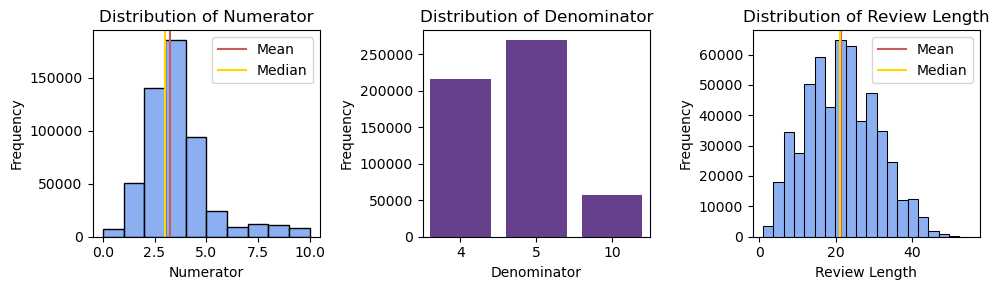

In [216]:
plt.subplots(1,3, figsize = (10,3))

plt.subplot(1,3,1)
# barplot for categorical variables
sns.histplot(x = final_df['num'], bins = 10, color = 'cornflowerblue')
plt.axvline(final_df['num'].mean(), color = 'indianred', label = 'Mean')
plt.axvline(final_df['num'].median(), color = 'gold', label = 'Median')
#labels
plt.title('Distribution of Numerator')
plt.xlabel('Numerator')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1,3,2)
# barplot for categorical variables
sns.countplot(x = final_df['denom'], color = 'rebeccapurple')
#labels
plt.title('Distribution of Denominator')
plt.xlabel('Denominator')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
# barplot for categorical variables
sns.histplot(x = final_df['review_length'],bins = 20, color = 'cornflowerblue')
plt.axvline(final_df['review_length'].mean(), color = 'indianred', label = 'Mean')
plt.axvline(final_df['review_length'].median(), color = 'gold', label = 'Median')
#labels
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()

# general
plt.tight_layout()
plt.show()

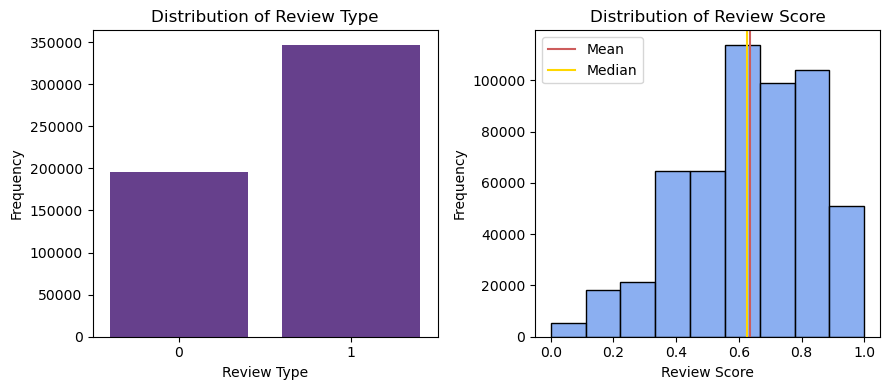

In [217]:
plt.subplots(1,2, figsize = (9,4))

plt.subplot(1,2,1)
# barplot for categorical variables
sns.countplot(x = final_df['review_type'], color = 'rebeccapurple')
#labels
plt.title('Distribution of Review Type')
plt.xlabel('Review Type')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
# barplot for categorical variables
sns.histplot(x = final_df['final_score'],bins = 9, color = 'cornflowerblue')
plt.axvline(final_df['final_score'].mean(), color = 'indianred', label = 'Mean')
plt.axvline(final_df['final_score'].median(), color = 'gold', label = 'Median')
#labels
plt.title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

plt.show()

The above shows that the two measure of review score, either binary or continuous, are not balanced. In particular, the percentage distribution of the `review_type` variable is calculated below.

In [24]:
# look into balance percentage of rating
values, counts = np.unique(final_df['review_type'], return_counts=True)
normalized_counts = counts/counts.sum()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

Class imbalance: [0.36 0.64]


This class imbalance will be investigated further within the **Sentiment Analysis** notebook, for which `review_type` is the target variable. For this, the current dataset is saved as a new file *reviews_for_vectorizing_full.csv* which will be used as the cleaned reviews dataset going forward.

In [42]:
# save to a csv before continuing
final_df.to_csv('data/reviews_for_vectorizing_full.csv')

# 2 Sentiment Input Function
Although the training data has been tokenised above in individual steps to assess the progression at each stage, when running the Sentiment Analysis on a live input provided by the user, these steps can be combined into one function in order to save time.

The function is defined below, which will take into account each of the steps that have been shown above.

In [212]:
# define tokenizer function for text input

def process_review(review):
    
    """
    This function is used to pre-process a review to then be used in a vectoriser
    The purpose of this function is to carry out all the NLP process steps used within the complete train and test set on
    which the model is being built. This means that any output from this function can then be run through the finalised 
    Sentiment Analysis model.
    
    Parameters:
    -----------
    
    review: Full text of a review.
            
    Returns:
    -------
    
    tokens: String output of review once it has gone through all the steps for NLP pre-processing.
    
    
    """
    # define stemmer
    stemmer = nltk.stem.PorterStemmer()
    
    #expand contractions
    cont_list = []
        
    for text in review.split(' '):
        cont = contractions.fix(text)
        cont_list.append(cont)
    
    review = ' '.join(cont_list)
    
    # remove punctuation and set to lower case
    for punc in string.punctuation:
        review = review.replace(punc,'').lower()

    # split review into individual words
    words_list = review.split(' ')
    stemmed_list = []
    
    # remove stopwords and any tokens that are empty strings
    for word in words_list:
        if (not word in stopwords.words('english')) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            stemmed_list.append(stemmed_word)
    
    # join back into a string
    tokens = ' '.join(stemmed_list)

    return tokens

A test of this function is carried out below to ensure it is effectively tokenising a potential review.

In [213]:
# function test
process_review('My only wish is that this movie had been longer, as I enjoyed every minute')

'wish movi longer enjoy everi minut'

This function will later be used within a python script to predict the sentimend of a review, alongside the .pkl file created from the optimised model for Sentiment Analysis.

# 3 User Relationships
This project involves a Collaborative Recommender System, which is centred around recommending movies based on the historical ratings of the user in question. In order to be able to use the critics within the reviews dataset as inputs to this system, their historical ratings must first be analysed and any strong relationships extracted to be used in testing later on.

The way in which this will be done is by looking at the genres for each of the reviewed movies, then using a function to find the average score and number of movies rated in each genre for each critic within the list. This will then allow for the extraction of any users with specific interests (i.e. Likes Romance, Dislikes Horror), which can be used as inputs for the Collaborative Recommender System later. This will counteract the *Cold Start* issue generally found when running this type of recommender system, as a new user will be able to locate an existing critic with similar interests.

This is the first investigation into the movies dataset, so the data dictionary for this data, which also comes from the *Rotten Tomatoes* website, is listed below.

|Column Name|Description|Data Type|
|-|-|-|
|`rotten_tomatoes_link`|Rotten Tomatoes url link relating to movie|string|
|`movie_title`|Title of the movie as displayed on the Rotten Tomatoes website|string|
|`movie_info`|Brief description of the movie|string|
|`critics_concensus`|Comment from Rotten Tomatoes|string|
|`content_rating`|Category based on the movie suitability for the audience|string|
|`genres`|Movie genres separated by commas|string|
|`directors`|Name of director(s)|string|
|`author`|Name of author(s)|string|
|`actors`|Name of actors in the movie|string|
|`original_release_date`|Date when the movie was released|string|
|`streaming_release_date`|Date when the movie was released for streaming|string|
|`runtime`|Movie runtime (in minutes)|float|
|`production_company`|Name of the production company|string|
|`tomatometer_status`|'Tomatometer' value: either 'Rotten', 'Fresh' or 'Certified Fresh'|string|
|`tomatometer_rating`|Percentage of positive critic ratings|float|
|`tomatometer_count`|Critic ratings counted for the calculation of the 'tomatometer_status'|float|
|`audience_status`|Audience rating value of 'Spilled' or 'Upright'|string|
|`audience_rating`|Percentage of positive audience ratings|float|
|`audience_count`|Audience ratings counted for the calculations of the 'audience_status'|float|
|`tomatometer_top_critics_count`|Count of total top critic ratings|integer|
|`tomatometer_fresh_critics_count`|Count of 'Fresh' top critic ratings|integer|
|`tomatometer_rotten_critics_count`|Count of 'Rotten' top critic ratings|integer|

The content of the `movies_df` is evaluated in more detail below.

In [209]:
# define contents
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [211]:
print(f'The movies dataset has {movies_df.shape[0]} rows and {movies_df.shape[1]} columns.')

The movies dataset has 17712 rows and 22 columns.


The above shows that there are a number of null values within the dataframe, but as all columns will not be used in the analysis these will be dealt with as needed.

## 3.1 Add Genres to Reviews
The first step in this process is to add the `genres` column from the *movies* dataframe to the `final_df` dataframe to include the genres associated to the movies which have been reviewed. In order to do this, first the `rotton_tomatoes_link` columns between both datasets are compared to ensure that the datasets are able to be successfully joined.

In [60]:
mov_id = movies_df['rotten_tomatoes_link'].value_counts().sum()
rev_id = final_df['rotten_tomatoes_link'].value_counts().count()
print(f'There are {mov_id-rev_id} more movies in the movies dataframe ({mov_id}) than the reviews dataframe ({rev_id}).')

There are 229 more movies in the movies dataframe (17712) than the reviews dataframe (17483).


There are fewer individual movies listed within the `final_df` than the original `movies_df`, which is due to the cleaning of the reviews dataset that has happened in a previous notebook. As these two dataframes will be combined using an inner join this won't cause an issue, however it is important to ensure that each of the `rotten_tomatoes_link` columns contain the same link for the relevant movies. This is checked below.

In [61]:
# make list containing all movie ids
mov_id_list = list(movies_df['rotten_tomatoes_link'].unique())
rev_id_list = list(final_df['rotten_tomatoes_link'].unique())

# loop through smaller list to ensure each value is in the larger list
for gen in rev_id_list:
    if gen in mov_id_list:
        continue
    else:
        print(gen)

m/-_man
m/-cule_valley_of_the_lost_ants
m/+_one_2019
m/+h
m/sympathy-for-the-devil-one-+-one


From some investigation into these links, which should be direct url input to the *Rotten Tomatoes* website, these are found to be associated to the following movie titles (and corrected links):

|Movie Title|*Reviews* Movie ID|*Correct* Movie ID|
|-|-|-|
|The Minus Man|m/-_man|m/-minusman|
|Minuscule Valley of the Lost Ants|m/-cule_valley_of_the_lost_ants|m/minuscule_valley_of_the_lost_ants|
|Plus One|m/+_one_2019|m/plus_one_2019|
|Plush|m/+h|m/plush|
|Sympathy for the Devil|m/sympathy-for-the-devil-one-+-one|m/sympathy-for-the-devil-one-plus-one|

These links are updated below.

In [68]:
# updating rotten tomatoes links
final_df['rotten_tomatoes_link'] = final_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/+_one_2019','m/plus_one_2019'))
final_df['rotten_tomatoes_link'] = final_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/+h','m/plush'))
final_df['rotten_tomatoes_link'] = final_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/-_man','m/minus_man'))
final_df['rotten_tomatoes_link'] = final_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/-cule_valley_of_the_lost_ants','m/minuscule_valley_of_the_lost_ants'))
final_df['rotten_tomatoes_link'] = final_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/sympathy-for-the-devil-one-+-one','m/sympathy-for-the-devil-one-plus-one'))

With these links updated, the two dataframes can now be joined together on the `rotten_tomatoes_link` column using an inner join to keep only the common movie information. This is carried out below.

In [70]:
# create new review df including movie genres
genre_rev_df = pd.merge(final_df, movies_df[['movie_title', 'genres', 'rotten_tomatoes_link']], \
                        on= 'rotten_tomatoes_link', how = 'inner')

#sanity check
genre_rev_df.head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score,review_length,stemmed,stem_str,movie_title,genres
0,m/0814255,Ben McEachen,False,Sunday Mail (Australia),1,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3.5,5,0.7,37,"[whether, audienc, get, behind, lightn, thief,...",whether audienc get behind lightn thief hard p...,Percy Jackson & the Olympians: The Lightning T...,"Action & Adventure, Comedy, Drama, Science Fic..."


This new joined dataframe is evaluated below.

In [71]:
# evaluate content
genre_rev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541937 entries, 0 to 541936
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  541937 non-null  object 
 1   critic_name           541937 non-null  object 
 2   top_critic            541937 non-null  bool   
 3   publisher_name        541937 non-null  object 
 4   review_type           541937 non-null  int64  
 5   review_score          541937 non-null  object 
 6   review_date           541937 non-null  object 
 7   review_content        541937 non-null  object 
 8   num                   541937 non-null  float64
 9   denom                 541937 non-null  int64  
 10  final_score           541937 non-null  float64
 11  review_length         541937 non-null  int64  
 12  stemmed               541937 non-null  object 
 13  stem_str              541937 non-null  object 
 14  movie_title           541937 non-null  object 
 15  

In this case, we are concerned with the genres of the movies, and the above indicates that there are some null values within the `genres` columnn.

In [72]:
# count null values
gen_null = genre_rev_df['genres'].isna().sum()
print(f'There are {gen_null} reviews with no allocated genre, covering {100*gen_null/genre_rev_df.shape[0]:.2f}% of the data.')

There are 113 movies with no allocated genre, covering 0.02% of the data.


As the assessment of the critics interests will be based on the genres, the reviews with no genres attached will be removed as they cannot offer insight on the user. This is considered acceptable as they cover such a small percentage of the overall reviews and cannot be easily filled.

In [73]:
# drop null genre movies
genre_rev_df.dropna(subset = 'genres', inplace = True)

In [75]:
# sanity check
genre_rev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541824 entries, 0 to 541936
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  541824 non-null  object 
 1   critic_name           541824 non-null  object 
 2   top_critic            541824 non-null  bool   
 3   publisher_name        541824 non-null  object 
 4   review_type           541824 non-null  int64  
 5   review_score          541824 non-null  object 
 6   review_date           541824 non-null  object 
 7   review_content        541824 non-null  object 
 8   num                   541824 non-null  float64
 9   denom                 541824 non-null  int64  
 10  final_score           541824 non-null  float64
 11  review_length         541824 non-null  int64  
 12  stemmed               541824 non-null  object 
 13  stem_str              541824 non-null  object 
 14  movie_title           541824 non-null  object 
 15  

In [76]:
# null genre count
gen_null2 = genre_rev_df['genres'].isna().sum()
print(f'There are now {gen_null2} movies with no allocated genre.')

There are now 0 movies with no allocated genre.


The final stage here is to split the `genres` column into a list, as this will allow for the genres to be evaluated more effectively.

In [79]:
# create a new column of genre list
genre_rev_df['genres_ls'] = genre_rev_df['genres'].str.split(', ')

# sanity check
genre_rev_df.head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score,review_length,stemmed,stem_str,movie_title,genres,genres_ls
0,m/0814255,Ben McEachen,False,Sunday Mail (Australia),1,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3.5,5,0.7,37,"[whether, audienc, get, behind, lightn, thief,...",whether audienc get behind lightn thief hard p...,Percy Jackson & the Olympians: The Lightning T...,"Action & Adventure, Comedy, Drama, Science Fic...","[Action & Adventure, Comedy, Drama, Science Fi..."


## 3.2 User-Genre Relationships
There are a number of possible movie genres to look into for possible relationships, but first a function will be made to assess all the movies of a specific genre and calculate the average score and number of reviews made by each individual critic, outputting these into individual dataframes. The function is defined below.

In [101]:
def genre_score(genre):
    
    """
    This function is used calculate the average score per critic for a given genre.
    The purpose of this function is for the user to define a genre, and the average rating for each movie with this genre
    is then calculated for each critic within genre_rev_df (along with the total number of movies rated in that genre).
    
    Parameters:
    -----------
    
    genre:  Extract of the movie genre that is to be evaluated. Must be within the list available within genre_rev_df.
    
            Drama, Comedy, Action & Adventure, Mystery & Suspense, Science Fiction & Fantasy, Romance, Horror, Art House 
            & International, Kids & Family, Documentary, Animation, Special Interest, Musical & Performing Arts, Classics, 
            Western, Sports & Fitness, Television, Cult Movies, Faith & Spirituality, Gay & Lesbian, Anime & Manga 
            
    Returns:
    -------
    
    genre_df: dataframe including the average score and number of reviews per for each critic for the given genre
    
    
    """
    
    #filter df for only reviews with that genre
    filtered_df = genre_rev_df[genre_rev_df['genres'].str.contains(genre)]
    
    # group by critic to find the mean score
    group = filtered_df.groupby(['critic_name'])['final_score'].aggregate(['mean','count'])
    
    # convert to dataframe
    genre_df = pd.DataFrame(group).reset_index()
    
    # rename columns
    genre_df = genre_df.rename(columns = {'mean':genre+'_sc','count':genre+'_n'})
    
    return genre_df

As a trial of the function, the 'Comedy' genre information is calculated below.

In [102]:
#trial for comedy genre
comedy_df = genre_score('Comedy')

# sanity check
comedy_df.head()

,critic_name,Comedy_sc,Comedy_n
0,A.A. Dowd,0.482353,17
1,A.H. Weiler,0.650000,6
2,A.O. Scott,0.582212,468
3,A.S. Hamrah,0.843750,4
4,AJ Caulfield,0.605000,10


The above shows a dataframe with both an average score and number of movies by each reviewer for the movies they reviewed which included the 'Comedy' genre. All the other possible genres to assess have been listed below.

In [91]:
# explode list to look into most common genres
genre_rev_df.explode('genres_ls')['genres_ls'].value_counts()

Drama                        300873
Comedy                       177593
Action & Adventure           143601
Mystery & Suspense           115325
Science Fiction & Fantasy     84584
Romance                       56068
Horror                        52135
Art House & International     51680
Kids & Family                 41321
Documentary                   36885
Animation                     29171
Special Interest              23853
Musical & Performing Arts     21739
Classics                      14925
Western                        5336
Sports & Fitness               4699
Television                     3119
Cult Movies                    1490
Faith & Spirituality           1183
Gay & Lesbian                   849
Anime & Manga                   359
Name: genres_ls, dtype: int64

The top ten genres will be assessed here, with a dataframe generated for each one below.

In [103]:
# create dfs for all top ten genres
drama_df = genre_score('Drama')
action_df = genre_score( 'Action')
mystery_df = genre_score('Mystery')
fantasy_df = genre_score('Fantasy')
romance_df = genre_score('Romance')
horror_df = genre_score('Horror')
international_df = genre_score('International')
family_df = genre_score('Family')
doc_df = genre_score('Documentary')

These will then be combined into one complete dataframe to be searched through for different patterns within users. First, a dataframe with only the possible names of the critics is created below, which will be used as the index to join the other tables on.

In [93]:
# create outline df with critic names
genrescore_df = pd.DataFrame({'critic_name': genre_rev_df['critic_name'].unique()}).sort_values('critic_name').reset_index()
genrescore_df.drop(columns = 'index', inplace = True)
genrescore_df.head()

,critic_name
0,A.A. Dowd
1,A.H. Weiler
2,A.J. Serrano
3,A.O. Scott
4,A.S. Hamrah


The join is then carried out, with the output being one dataframe containing measured values for all of the top 10 genres for each critic.

In [104]:
# list all genre dfs
genre_list = [genrescore_df, comedy_df, drama_df, action_df, mystery_df, fantasy_df,\
              romance_df, horror_df, international_df, family_df,doc_df]

# define index to be joined on for each df (critic_name)
genre_list = [df.set_index('critic_name') for df in genre_list]

# create new df joining all genre dfs to the critic name df via their common index 
criticgenres_df = genre_list[0].join(genre_list[1:])

# reset index
criticgenres_df = criticgenres_df.reset_index()
# sanity check
criticgenres_df.head()

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
0,A.A. Dowd,0.482353,17.0,0.552000,25.0,0.400000,7.0,0.575000,8.0,0.5000,...,0.533333,3.0,0.480000,5.0,0.750000,4.0,0.400000,2.0,0.600000,5.0
1,A.H. Weiler,0.650000,6.0,0.652778,18.0,0.578571,7.0,0.558333,6.0,0.6125,...,0.566667,6.0,0.516667,6.0,0.643750,8.0,0.700000,3.0,NaN,NaN
2,A.J. Serrano,NaN,NaN,NaN,NaN,0.250000,1.0,0.250000,1.0,0.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A.O. Scott,0.582212,468.0,0.625225,779.0,0.531197,234.0,0.567689,212.0,0.5600,...,0.587919,149.0,0.494000,50.0,0.694183,202.0,0.560494,81.0,0.720779,154.0
4,A.S. Hamrah,0.843750,4.0,0.812500,4.0,NaN,NaN,NaN,NaN,NaN,...,0.875000,1.0,NaN,NaN,0.750000,1.0,NaN,NaN,NaN,NaN


This shows that there are the occasional *NaN* scores, linked to when that critic has never rated a movie of that specific genre. In these instances, the score and number of reviews will be set to equal zero to avoid any potential errors.

In [105]:
criticgenres_df.fillna(0, inplace = True)
criticgenres_df.head()

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
0,A.A. Dowd,0.482353,17.0,0.552000,25.0,0.400000,7.0,0.575000,8.0,0.5000,...,0.533333,3.0,0.480000,5.0,0.750000,4.0,0.400000,2.0,0.600000,5.0
1,A.H. Weiler,0.650000,6.0,0.652778,18.0,0.578571,7.0,0.558333,6.0,0.6125,...,0.566667,6.0,0.516667,6.0,0.643750,8.0,0.700000,3.0,0.000000,0.0
2,A.J. Serrano,0.000000,0.0,0.000000,0.0,0.250000,1.0,0.250000,1.0,0.2500,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,A.O. Scott,0.582212,468.0,0.625225,779.0,0.531197,234.0,0.567689,212.0,0.5600,...,0.587919,149.0,0.494000,50.0,0.694183,202.0,0.560494,81.0,0.720779,154.0
4,A.S. Hamrah,0.843750,4.0,0.812500,4.0,0.000000,0.0,0.000000,0.0,0.0000,...,0.875000,1.0,0.000000,0.0,0.750000,1.0,0.000000,0.0,0.000000,0.0


## 3.3 Finding Users
Users with specific tastes can now be found by searching through this database for relative scores in specific genres. To do this, another function has been defined below.

In [116]:
def find_critic(likes, dislikes, like_score = 0.65, dislike_score = 0.35, reviews = 10):
    
    """
    This function is used to find names of critics with specific genre interests.
    The purpose of this function is to provide a list of critic names with interests that may align with a new user,
    so this critic's historical ratings can be used to calculate a new top ten recommendations list.
    
    Parameters:
    -----------
    
    likes:  Genre that the user likes
            Needs to be an exact match to the genres available within the 'criticgenres_df'
            Comedy, Drama, Action, Mystery, Fantasy, Romance, Horror, International, Family, Documentary
    dislikes:   Genre that the user dislikes
                Needs to be an exact match to the genres available within the 'criticgenres_df' (as above)
    like_score: Minimum average score for the 'likes' genre for the critic to be considered
                default = 0.65
    dislike_score: Maximum average score for the 'dislikes' genre for the critic to be considered
                default = 0.35
    reviews: Minimum number of reviews that the critic must have entered for each of the genres mentioned in order to be considered
             default = 10
            
    Returns:
    -------
    
    critics: Filtered 'criticgenres_df' showing only the names of critics who meet the given criteria
    
    
    """
    # find average score column name for 'likes' genre
    likes_val = likes + '_sc'
    # find count column name for 'likes' genre
    likes_num = likes + '_n'
    # find average score column name for 'dislikes' genre
    dislikes_val = dislikes + '_sc'
    # find count column name for 'dislikes' genre
    dislikes_num = dislikes + '_n'
    
    # conditional filtering to only include 'likes' score above input value, 'dislikes' score below input value
    # and both counts to be above input value
    critics = criticgenres_df[((criticgenres_df[likes_num]>=reviews) & (criticgenres_df[likes_val]>like_score) & \
                 (criticgenres_df[dislikes_num]>=reviews) & (criticgenres_df[dislikes_val]<dislike_score))]
    return critics

In [110]:
# like romance, dislike horror
find_critic('Romance', 'Horror', 0.65, 0.4, reviews = 10)

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
5274,Sarah Chauncey,0.544178,73.0,0.649597,62.0,0.51,35.0,0.5425,30.0,0.511765,...,0.6625,22.0,0.352083,12.0,0.0,0.0,0.535526,19.0,0.875,2.0


In [132]:
# like action, dislike international
find_critic('Action', 'International', 0.7, 0.5, reviews = 5)

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
5542,Stefan Birgir Stefansson,0.649194,93.0,0.676103,68.0,0.706105,86.0,0.666358,81.0,0.652035,...,0.682143,14.0,0.5784,125.0,0.4625,12.0,0.636765,17.0,0.8125,8.0


In [179]:
# like horror, dislike fantasy
find_critic('Horror', 'Fantasy', 0.65, 0.45, reviews = 2)

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
678,Betsy Sherman,0.587121,33.0,0.680000,25.0,0.557692,13.0,0.642857,7.0,0.250000,...,0.527778,9.0,0.71875,4.0,0.712500,10.0,0.5000,2.0,0.734375,8.0
4827,R. Kurt Osenlund,0.523438,48.0,0.524722,90.0,0.473529,34.0,0.543182,22.0,0.401786,...,0.460938,16.0,0.68750,2.0,0.614286,7.0,0.5125,10.0,0.461111,9.0
5739,Teresa Jusino,0.900000,1.0,0.787500,8.0,0.750000,2.0,0.833333,3.0,0.450000,...,0.800000,4.0,0.85000,2.0,0.000000,0.0,0.7000,3.0,0.000000,0.0


In [181]:
# like mystery dislike fantasy
find_critic('Mystery', 'Fantasy', like_score = 0.6, dislike_score = 0.4, reviews = 5)

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
3139,José Arce,0.633333,3.0,0.566667,15.0,0.533333,9.0,0.607692,13.0,0.385714,...,0.300000,1.0,0.583333,6.0,0.80,1.0,0.700000,3.0,0.00,0.0
5826,Toby Young,0.491667,24.0,0.600000,26.0,0.512500,16.0,0.636364,11.0,0.360000,...,0.542857,7.0,0.533333,3.0,0.62,10.0,0.433333,6.0,0.55,4.0


In [208]:
# like comedy, dislike horror
find_critic('Comedy', 'Horror', 0.7, 0.3, reviews = 2)

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
22,Aarón Rodríguez Serrano,0.800000,2.0,0.625000,8.0,0.80,2.0,0.700000,2.0,0.0,...,0.000000,0.0,0.200000,2.0,0.6,1.0,0.0,0.0,0.8,1.0
3500,Larry Carroll,0.711111,18.0,0.634483,29.0,0.65,20.0,0.552941,17.0,0.4,...,0.533333,6.0,0.266667,3.0,0.8,2.0,0.7,2.0,0.4,1.0


In [197]:
# like drama, dislike action
find_critic('Drama', 'Action', 0.73, 0.6, reviews = 10)

,critic_name,Comedy_sc,Comedy_n,Drama_sc,Drama_n,Action_sc,Action_n,Mystery_sc,Mystery_n,Fantasy_sc,...,Romance_sc,Romance_n,Horror_sc,Horror_n,International_sc,International_n,Family_sc,Family_n,Documentary_sc,Documentary_n
766,Brandon Judell,0.606875,40.0,0.773026,76.0,0.558000,25.0,0.677885,26.0,0.548684,...,0.705556,27.0,0.565909,11.0,0.833333,24.0,0.478125,8.0,0.788889,9.0
968,Cate Marquis,0.671324,34.0,0.771680,128.0,0.581579,19.0,0.700000,18.0,0.628571,...,0.711765,17.0,0.550000,4.0,0.864706,17.0,0.600000,6.0,0.806667,15.0
2431,Jack Blackwell,0.733333,9.0,0.733333,54.0,0.569231,13.0,0.733333,15.0,0.666667,...,0.600000,3.0,0.760000,5.0,0.720000,5.0,0.800000,2.0,0.800000,2.0
2526,James O'Ehley,0.662500,40.0,0.750000,59.0,0.580556,126.0,0.675000,53.0,0.629787,...,0.730000,10.0,0.595946,37.0,0.841667,9.0,0.626316,19.0,0.600000,1.0
5223,Sam Watermeier,0.727273,11.0,0.761290,31.0,0.581818,11.0,0.666667,9.0,0.620000,...,0.400000,1.0,0.633333,6.0,0.700000,3.0,0.600000,3.0,0.820000,5.0
5835,Tom Augustine,0.625000,16.0,0.742105,38.0,0.526316,19.0,0.660000,15.0,0.575000,...,0.800000,2.0,0.675000,8.0,0.850000,6.0,0.600000,1.0,0.800000,4.0


From the above investigations, the following list of users will be used to test out the collaborative recommender system:

|Name|Likes|Dislikes|
|-|-|-|
|Sarah Chauncey|Romance, Drama| Horror|
|Stefan Birgir Stefansson|Action, Documentary| International|
|Gary Brown|Family, Documentary| Horror|
|Larry Carroll|Comedy| Horror|
|R. Kurt Osenlund|Horror, International|Fantasy|
|Toby Young|Drama, Mystery|Fantasy|
|David Blaustein|Fantasy, Mystery|Romance|
|Brandon Judell|International|Fantasy|
|Jack Blackwell| Drama |Romance, Action|

# 4 Next Steps
The next stage of the project is to begin initiation of the four tasks that are to be undertaken. These are available in the following notebook files:
- Sentiment Analysis
- Content Based Recommender System
- User Based & Collaborative Recommender Systems

---